# Automated Extraction of 3D Seed Phenotype Data using a pre-trained `StarDist` model, `Scivision`, and `Pixelflow`

### This notebook demonstrates how to use pixelflow to extract measurements of segmented objects from 3D imagery. This demo will use 3D x-ray computed tomography images of Oilseed rape (*Brassica napus*) seedpods detected and segmented using an adapted StarDist model as described in [Corcoran et al. 2023](https://www.frontiersin.org/articles/10.3389/fpls.2023.1120182/full).

### Example images required to run this notebook can be found [here](https://zenodo.org/records/8355920)

### R code used to run valve sorting in this notebook is available from the [Scivision gallery github page](https://github.com/scivision-gallery/pixelflow_seed_demo/tree/main) seed (`'seedpod_valve_lowess_single.R'`)

## 1. Install and load relevant packages

In [1]:
from pixelflow import pixelflow

import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
from pathlib import Path

from glob import glob
import re

from scivision import default_catalog, load_pretrained_model

## 2. Find `StarDist Seed` model in `Scivision` model catalog

In [2]:
# load full scivision model catalog
models_catalog = default_catalog.models.to_dataframe()
models_catalog

,name,description,tasks,pkg_url,url,scivision_usable,institution,tags
0,stardist,Single class object detection and segementatio...,"(TaskEnum.object_detection, TaskEnum.segmentat...",git+https://github.com/stardist/stardist.git@m...,https://github.com/stardist/stardist,False,"(epfl,)","(2D, 3D, optical-microscopy, xray, microtomogr..."
1,PlantCV,Open-source image analysis software package ta...,"(TaskEnum.thresholding, TaskEnum.object_detect...",git+https://github.com/danforthcenter/plantcv@...,https://github.com/danforthcenter/plantcv,False,"(danforthcenter,)","(2D, hyperspectral, multispectral, near-infrar..."
2,greenotyper,Greenotyper is an image analysis tool for larg...,(TaskEnum.segmentation),git+https://github.com/MarniTausen/Greenotyper...,https://github.com/MarniTausen/Greenotyper,False,"(MarniTausen,)","(2D, multispectral, plant-phenotyping, climate..."
3,mapreader-plant,automated detection of plant patches in images...,"(TaskEnum.object_detection, TaskEnum.classific...",git+https://github.com/alan-turing-institute/m...,https://github.com/alan-turing-institute/mapre...,True,"(alan-turing-institute,)","(2D, plant, phenotype, rgb, biology, agriculture)"
4,resnet50-plankton,automated classification of plankton images co...,(TaskEnum.classificiation),git+https://github.com/alan-turing-institute/p...,https://github.com/alan-turing-institute/plank...,True,"(alan-turing-institute, cefas, plankton-analyt...","(2D, plankton, ecology, environmental-science)"
5,vedge-detector,automated detection of coastal vegetation edge...,(TaskEnum.segmentation),git+https://github.com/MartinSJRogers/VEdge_De...,https://github.com/MartinSJRogers/VEdge_Detect...,True,"(cambridge-university, birkbeck-university)","(2D, satellite, remote-sensing, ecology, envir..."
6,image-classifiers,Scivision plugin for the image-classifiers pac...,(TaskEnum.classificiation),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute,)","(classification, 2D, image)"
7,huggingface-classifiers,Selection of image classifiers taken from http...,(TaskEnum.classificiation),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute, huggingface)","(classification, 2D, image)"
8,huggingface-segmentation,Selection of segmentation algorithms taken fro...,(TaskEnum.segmentation),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute, huggingface)",()
9,huggingface-object-detection,Selection of object detection algorithms taken...,(TaskEnum.object_detection),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute, huggingface)",()


In [3]:
#get github repository link for the model we want to use (StarDist Seed)
model_repo = models_catalog[models_catalog.name == "StarDist Seed"].url.item()
model_repo

FlexibleUrl('https://raw.githubusercontent.com/alan-turing-institute/stardist-seed-pod/main/.scivision/model.yml', scheme='https', host='raw.githubusercontent.com', tld='com', host_type='domain', path='/alan-turing-institute/stardist-seed-pod/main/.scivision/model.yml')

## 3. Load `StarDist Seed` model from `Scivision` model catalog

In [4]:
#load pretrained seed model
model = load_pretrained_model(model_repo, model_selection='model_3d', allow_install=True)
model

[09:48:25] INFO     Call='load_pretrained_model', module='scivision.io.reader', signature=(path:        ]8;id=32438;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/scivision/koala.py\koala.py]8;;\:]8;id=876671;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/scivision/koala.py#49\49]8;;\
                    os.PathLike, branch: str = 'main', allow_install: bool = False, model_selection:               
                    str = 'default', load_multiple: bool = False, *args, **kwargs) ->                              
                    scivision.io.wrapper.PretrainedModel, kwargs_given='model_selection, allow_install'            

2024-02-06 09:48:27.867486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.7, nms_thresh=0.3.


2024-02-06 09:48:41.916766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


scivision.PretrainedModel( 
  module='stardist_seed_pod', 
  model='model_3d', 
  source='https://github.com/alan-turing-institute/stardist-seed-pod' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

# Extract seed size and shape metrics from a single image (one seed pod) with `Pixelflow`

## 4. Load images

In [5]:
#load image
img = imread('C0007197.tif')
pod_name = 'C0007197'

## 5. Predict location, size and shape of seeds with `StarDist Seed` model using `Scivision `core function

In [6]:
#detect and segment seeds in image
pred = model.predict(img)

In [7]:
#save seed labels created with Stardist Seed model
np.save(Path('content/'+ pod_name + '_pred.npy'), pred)

## 6. Calculate seed size, shape and arrangement metrics with `Pixelflow`

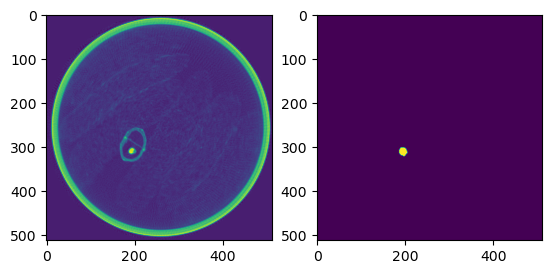

In [8]:
#load image and mask
img = imread('C0007197.tif')
mask = pred

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[img.shape[0]//2])
ax[1].imshow(mask[mask.shape[0]//2])

In [9]:
#create table of size and shape metrics
features = pixelflow(
    mask,
    img,
    spacing=(0.03,0.03,0.03),
    features=('label', 'bbox', 'centroid', 'volume', 'surface_area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'sphericity', 'solidity', 'image_intensity'),
)

ZYX image detected


In [10]:
#show table of size and shape metrics in millimetres
features

,label,minor_axis_length,major_axis_length,equivalent_diameter,centroid-0,centroid-1,centroid-2,solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,sphericity,surface_area
0,1,0.981203,1.125500,1.033669,7.057080,9.182320,6.880791,0.944606,218,290,212,252,323,249,0.578286,0.840046,3.995854
1,2,0.967379,1.094070,1.021443,8.402966,8.423045,6.856169,0.948071,264,263,213,296,299,246,0.558009,0.897028,3.654030
2,3,0.931310,1.081708,0.993973,9.786055,9.224335,6.038981,0.942772,311,292,184,342,324,219,0.514188,0.881338,3.521730
3,4,0.993609,1.141612,1.068682,10.523322,8.308133,6.350884,0.946646,334,259,194,368,296,229,0.639063,0.857784,4.182815
4,5,0.972978,1.101306,1.022085,11.903140,8.292396,6.207130,0.944272,381,259,191,412,295,224,0.559062,0.883887,3.713021
5,6,1.039169,1.100054,1.064269,12.965118,9.242935,5.640875,0.947243,415,292,172,450,325,206,0.631179,0.904121,3.935736
6,7,0.998850,1.109968,1.049012,13.755882,8.356721,6.144574,0.946674,442,261,188,475,297,222,0.604422,0.891599,3.877405
7,8,0.996690,1.113522,1.040445,14.965326,9.286118,5.784761,0.943947,482,293,176,516,326,211,0.589734,0.876820,3.878623
8,9,1.023502,1.117775,1.057196,16.262782,9.277510,5.758335,0.945024,525,292,175,559,326,210,0.618678,0.897796,3.910957
9,10,1.011778,1.101909,1.058210,18.252815,8.195342,6.873644,0.949508,592,256,213,626,291,247,0.620460,0.912699,3.854480


In [11]:
#output csv with measurements
features.to_csv('C0007197.csv', header=True, index=False)

## 7. Save segmented images of each individual seed with `Pixelflow`

In [12]:
#make list of all seeds in mask, shift backwards by one to match index values
X = list(features.features.label)
for i in range(len(X)):
    X[i] -= 1

In [13]:
#save segmented images of all seeds within a seed pod
for file in X:
    np.save(pod_name + '_seed_' + str(features.features.label[file]) + '.npy', features.image_intensity[file])

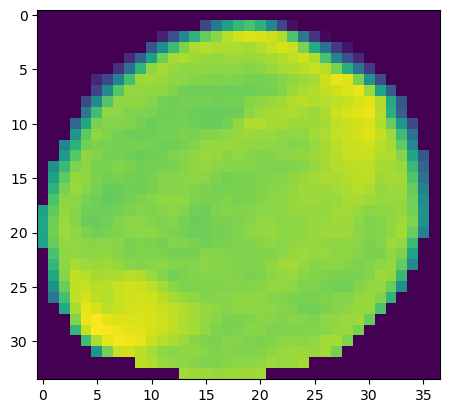

In [14]:
#load single seed image
seed_image = np.load('C0007197_seed_1.npy')

fig = plt.imshow(seed_image[:, seed_image.shape[1]//2])

# Extract seed size and shape metrics and single seed images from multiple images (one seed pod per image) with `Pixelflow`

In [15]:
#load all input images
img_list = sorted(glob('content/*.tif'))
img_list

['content/C0007158.tif',
 'content/C0007159.tif',
 'content/C0007198.tif',
 'content/C0007205.tif',
 'content/C0007226.tif',
 'content/C0007239.tif']

In [16]:
for file in img_list:
  #load image and mask
  img = imread(file)
  pod_name = re.split("[/.]", file)[-2]
  pred = model.predict(img)
  np.save(Path('content/'+ pod_name + '_pred.npy'), pred)
  mask = pred

  #create table of size and shape metrics
  features = pixelflow(
    mask,
    img,
    spacing=(0.03,0.03,0.03),
    features=('label', 'bbox', 'centroid', 'volume', 'surface_area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'sphericity', 'solidity', 'image_intensity'),
  )
  #output csv with measurements
  features.to_csv(pod_name + '.csv', header=True, index=False)

  #make list of all seeds in mask, shift backwards by one to match index values
  X = list(features.features.label)
  for i in range(len(X)):
      X[i] -= 1

  #save segmented images of all seeds within a seed pod
  for file in X:
      np.save(pod_name + '_seed_' + str(features.features.label[file]) + '.npy', features.image_intensity[file])

ZYX image detected
ZYX image detected
ZYX image detected
ZYX image detected
ZYX image detected
ZYX image detected


## 8. Sort detected seeds into 2 seeds pod valves, and calculated related measurments (order in valve from seed pod beak to pedicel, space between seeds in each valve) with `'seedpod_valve_lowess_single.R'`

In [17]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion, default_converter
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

In [18]:
# R packages to install
with conversion.localconverter(default_converter):
  utils = rpackages.importr('utils')
  utils.chooseCRANmirror(ind=1)
  packnames = ('gplots', 'tidyverse')
  # Selectively install what needs to be install.
  names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
  if len(names_to_install) > 0:
      utils.install_packages(StrVector(names_to_install))

In [19]:
# Defining the R script and loading the instance in Python
r = robjects.r

In [20]:
for file in img_list:
  # Calculate the image data in pixelflow
  img2 = imread(file)
  pod_name = re.split("[/.]", file)[-2]
  mask2 = np.load(Path('content/'+ pod_name + '_pred.npy'))
  features2 = pixelflow(mask2, img2, features=('label', 'bbox', 'centroid', 'volume', 'surface_area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'sphericity', 'solidity', 'image_intensity'))
  # Loading the function we have defined in R.
  with conversion.localconverter(default_converter):
      r['source']('seedpod_2D_valve_lowess_single.R')
      seedpod_2D_single_r = robjects.globalenv['seedpod_2D_single']

  #converting dataframe into r object for passing into r function
  with (robjects.default_converter + pandas2ri.converter).context():
    r_from_pd_df = robjects.conversion.get_conversion().py2rpy(features2.features)

  #Invoking the R function and getting the result
  with conversion.localconverter(default_converter):
      df_result_r = seedpod_2D_single_r(r_from_pd_df, "plot_" + pod_name + ".png")

  #Converting it back to a pandas dataframe
  with (robjects.default_converter + pandas2ri.converter).context():
    df_result = robjects.conversion.get_conversion().rpy2py(df_result_r)

ZYX image detected
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[10:31:20] WARNING  R[write to console]:                                                           ]8;id=840231;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=926700;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                    Attaching package: ‘gplots’                                                                    
                                                                                                                   
                                                                                                                   

           WARNING  R[write to console]: The following object is masked from ‘package:stats’:      ]8;id=787429;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=409067;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                                                                                                                   
                        lowess                                                                                     
                                                                                                                   
                                                                                                                   

ZYX image detected
ZYX image detected
ZYX image detected
ZYX image detected
ZYX image detected
